<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Joint reactions](02.02-joint-reactions.ipynb) | [Contents](Index.ipynb) | [Analyses](03.00-experts-novices.ipynb) >

# Simple ergonomics indicator

- box-chest distance
- box inclination
- hip-floor distance

In [1]:
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import altair as alt
from pyosim import Conf
from pyomeca import Markers3d, Analogs3d
import spm1d
import matplotlib.pyplot as plt

from src.util import (
    parse_conditions,
    condition_counter,
    random_balanced_design,
    get_spm_cluster,
    ridge_plot,
    describe_clusters,
)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("json")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
aws_conf = yaml.safe_load(open("../conf.yml"))

conf = Conf(project_path=aws_conf["path"]["project"]["local"])
conf.check_confs()

Project loaded
Configuration file loaded


In [4]:
offset = 0.05  # take .5 second before and after onsets
onsets = (
    pd.concat(
        [
            pd.DataFrame(conf.get_conf_field(filename.parent.stem, ["onset"])).T
            for filename in conf.project_path.glob("*/_conf.json")
        ]
    )
    .rename(columns={0: "onset", 1: "offset"})
    .eval("onset = onset - @offset")
    .eval("offset = offset + @offset")
)

onsets.head()

,onset,offset
CamBF12H6_3,1.0765,4.7350
CamBF12H1_1,0.8085,3.5340
CamBF12H1_2,0.8925,3.8740
CamBF12H1_3,0.8360,3.7105
CamBF12H2_1,0.9485,4.4905


In [5]:
def cut_trial(x, onset):
    idx = np.logical_and(
        x.get_time_frames < onset.loc["offset"], x.get_time_frames > onset.loc["onset"]
    )
    return x[..., idx]

## Box-chest distance

In [6]:
box_markers = [
    "boite_avant_gauche_X",
    "boite_avant_gauche_Y",
    "boite_avant_gauche_Z",
    "boite_avant_droit_X",
    "boite_avant_droit_Y",
    "boite_avant_droit_Z",
    "boite_arriere_droit_X",
    "boite_arriere_droit_Y",
    "boite_arriere_droit_Z",
    "boite_arriere_gauche_X",
    "boite_arriere_gauche_Y",
    "boite_arriere_gauche_Z",
]


def box_thorax_distance(x):
    box = pd.concat(
        [x[box_markers].filter(like=i).mean(axis=1).rename(i) for i in ["X", "Y", "Z"]],
        axis=1,
    )
    thorax = x.filter(like="XIPH").rename(columns=lambda x: x.replace("XIPH_", ""))
    return (
        np.sqrt(((box - thorax) ** 2).sum(axis=1))
        .replace(0, np.nan)
        .interpolate()
        .rename("box_thorax")
        .to_frame()
    )

In [7]:
height = (
    pd.read_csv(conf.conf_path)
    .query("process == 1")[["participant", "height"]]
    .rename(columns={"height": "p_height"})
)

In [9]:
box_thorax = (
    pd.concat(
        [
            cut_trial(Markers3d.from_trc(ifile), onsets.loc[ifile.stem])
            .time_normalization()
            .to_dataframe()
            .pipe(box_thorax_distance)
            .assign(filename=ifile.stem)
            if ifile.stem in onsets.index
            else pd.DataFrame()
            for ifile in conf.project_path.glob("*/0_markers/*H2*.trc")
        ]
    )
    .dropna()
    .pipe(parse_conditions)
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .query("mass != 18 & height == 2")
)

In [10]:
box_thorax.head()

,index,box_thorax,filename,participant,men,height,mass,n_trial
0,0.00,413.990558,CamBF12H2_2,camb,0,2,12,2
1,0.01,412.513355,CamBF12H2_2,camb,0,2,12,2
2,0.02,410.818907,CamBF12H2_2,camb,0,2,12,2
3,0.03,408.795449,CamBF12H2_2,camb,0,2,12,2
4,0.04,407.010019,CamBF12H2_2,camb,0,2,12,2


In [11]:
box_thorax = (
    box_thorax.merge(height, on="participant", how="left")
    .eval("box_thorax = box_thorax / (p_height * 10)")
    .drop("p_height", axis=1)
    .dropna()
)

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [12]:
to_bold = lambda x: "\033[1m" + x + "\033[0m"

print(to_bold("Initial"))
condition_counter(box_thorax)

Initial
n. participants: 39
----------
men
0    112
1    117
----------
height
2    229
----------
mass
6     114
12    115
----------
men  mass
0    6       55
     12      57
1    6       59
     12      58
----------


In [13]:
balanced_trials = random_balanced_design(
    box_thorax, ["men", "mass"], random_state=RANDOM_SEED
)["filename"].tolist()
box_thorax = box_thorax.query("filename == @balanced_trials")

print(to_bold("Balanced:"))
condition_counter(box_thorax)

Balanced:
n. participants: 39
----------
men
0    110
1    110
----------
height
2    220
----------
mass
6     110
12    110
----------
men  mass
0    6       55
     12      55
1    6       55
     12      55
----------


### Stats

In [14]:
id_vars = ["filename", "participant", "men", "height", "mass", "n_trial", "index"]
y = (
    box_thorax.assign(
        participant=lambda x: x["participant"].astype("category").cat.codes
    )
    .set_index(id_vars)
    .unstack()
)
y = y.fillna(y.mean())

y.head()

box_thorax            \
index                                                 0.00      0.01   
filename    participant men height mass n_trial                        
AimQF12H2_1 0           0   2      12   1         0.269848  0.269636   
AimQF12H2_2 0           0   2      12   2         0.265496  0.263634   
AimQF12H2_3 0           0   2      12   3         0.228306  0.225918   
AimQF6H2_1  0           0   2      6    1         0.314029  0.315123   
AimQF6H2_2  0           0   2      6    2         0.304670  0.305591   

                                                                               \
index                                                0.02      0.03      0.04   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        0.269504  0.268863  0.268449   
AimQF12H2_2 0           0   2      12   2        0.262327  0.260874  0.259805   
AimQF12H2_3 0           0   2      12   3        0.223992  0.222429  0.221814   
AimQF6H2_1  0           0   2      6    1        0.316564  0.318019  0.318459   
AimQF6H2_2  0           0   2      6    2        0.306537  0.307721  0.309240   

                                                                               \
index                                                0.05      0.06      0.07   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        0.268970  0.270208  0.271879   
AimQF12H2_2 0           0   2      12   2        0.259139  0.258734  0.258568   
AimQF12H2_3 0           0   2      12   3        0.222089  0.223651  0.227191   
AimQF6H2_1  0           0   2      6    1        0.317952  0.316161  0.312753   
AimQF6H2_2  0           0   2      6    2        0.310680  0.311101  0.309852   

                                                                     ...  \
index                                                0.08      0.09  ...   
filename    participant men height mass n_trial                      ...   
AimQF12H2_1 0           0   2      12   1        0.273556  0.274588  ...   
AimQF12H2_2 0           0   2      12   2        0.259032  0.260475  ...   
AimQF12H2_3 0           0   2      12   3        0.232041  0.237110  ...   
AimQF6H2_1  0           0   2      6    1        0.307791  0.302129  ...   
AimQF6H2_2  0           0   2      6    2        0.307848  0.304581  ...   

                                                                               \
index                                                0.91      0.92      0.93   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        0.326200  0.326809  0.328060   
AimQF12H2_2 0           0   2      12   2        0.317531  0.318506  0.319782   
AimQF12H2_3 0           0   2      12   3        0.298705  0.298826  0.318814   
AimQF6H2_1  0           0   2      6    1        0.394906  0.394859  0.394235   
AimQF6H2_2  0           0   2      6    2        0.395749  0.395402  0.394654   

                                                                               \
index                                                0.94      0.95      0.96   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        0.329311  0.331240  0.333867   
AimQF12H2_2 0           0   2      12   2        0.321852  0.323915  0.324954   
AimQF12H2_3 0           0   2      12   3        0.301239  0.302642  0.304500   
AimQF6H2_1  0           0   2      6    1        0.394185  0.394008  0.394177   
AimQF6H2_2  0           0   2      6    2        0.393618  0.394432  0.395370   

                                                                               \
index                                                0.97      0.98      0.99   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0          

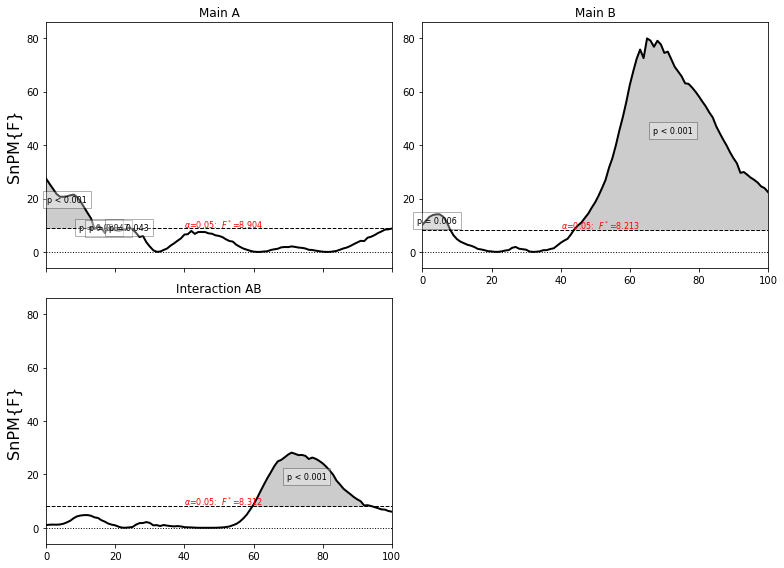

In [15]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [16]:
effect = {
    "Main A": "main sex",
    "Main B": "main mass",
    "Interaction AB": "interaction sex-mass",
}

clusters = get_spm_cluster(spmi, labels=effect, mult=1 / y.shape[1])
clusters

,effect,p,start,end
0,main sex,0,0,0.137719
1,main sex,0.0376667,0.141736,0.158724
2,main sex,0.047,0.177798,0.180197
3,main sex,0.0426667,0.234381,0.241272
4,main mass,0.006,0,0.0802752
5,main mass,0,0.433992,0.990099
6,interaction sex-mass,0,0.592039,0.925418


In [18]:
effect = {"main sex": "men", "main mass": "mass", "interaction sex-mass": "men"}
clusters = describe_clusters(
    clusters, box_thorax.rename(columns=dict(box_thorax="value")), effect
)
clusters

,effect,p,start,end,diff desc,mean diff,cohen d,cohen effect
0,main sex,0.000,0.00,0.14,0 - 1,-0.02,-0.53,medium
4,main mass,0.006,0.00,0.08,12 - 6,0.01,0.47,small
5,main mass,0.000,0.43,0.99,12 - 6,0.03,0.56,medium
6,interaction sex-mass,0.000,0.59,0.93,0 - 1,-0.00,-0.02,no


In [25]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [26]:
base = alt.Chart(box_thorax).encode(
    alt.X(
        "index", title="normalized trial", axis=alt.Axis(format="%", labelFlush=False)
    )
)
mu = base.mark_line().encode(
    alt.Y(
        "mean(box_thorax)",
        title="box-thorax distance (% height)",
        axis=alt.Axis(format="%"),
    )
)
sigma = base.mark_errorband(extent="ci").encode(alt.Y("box_thorax", title=None))
men_scale = alt.Scale(scheme="set1")

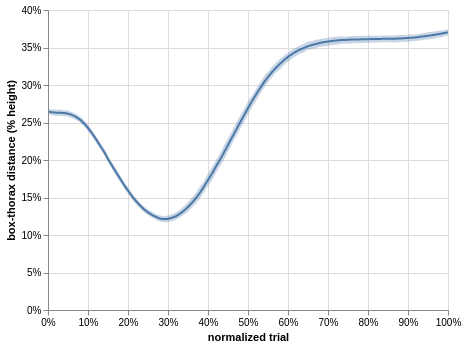

In [27]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

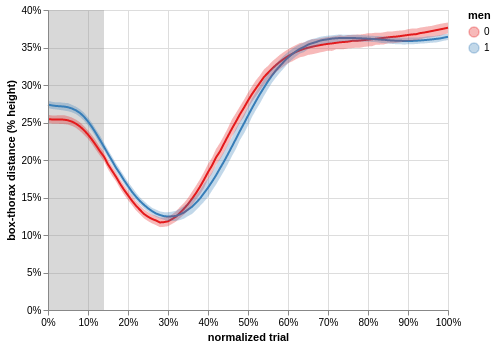

In [28]:
c.transform_filter('datum.effect == "main sex"') + (mu + sigma).encode(
    alt.Color("men:N", scale=men_scale)
)

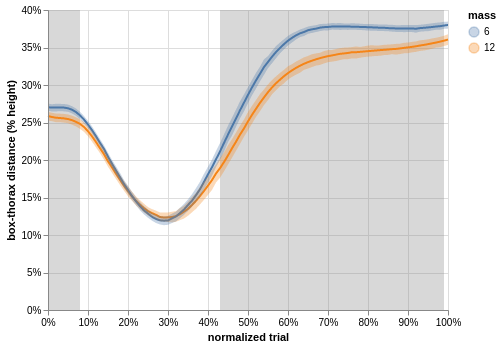

In [29]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

In [30]:
clusters.query('effect == "interaction sex-mass"')

,effect,p,start,end,diff desc,mean diff,cohen d,cohen effect
6,interaction sex-mass,0.0,0.59,0.93,0 - 1,-0.0,-0.02,no


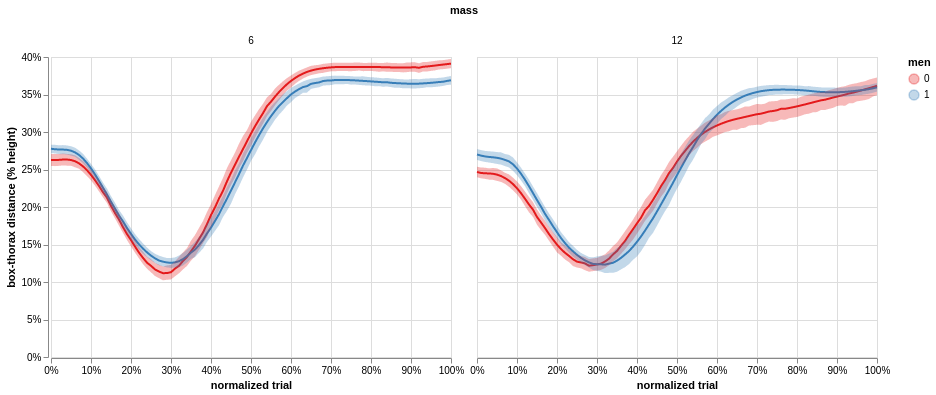

In [31]:
(mu + sigma).encode(alt.Color("men:N", scale=men_scale)).facet(column="mass")

## Hip vertical displacement

In [32]:
hip_markers = [
    "ASISl_X",
    "ASISl_Y",
    "ASISl_Z",
    "ASISr_X",
    "ASISr_Y",
    "ASISr_Z",
    "PSISl_X",
    "PSISl_Y",
    "PSISl_Z",
    "PSISr_X",
    "PSISr_Y",
    "PSISr_Z",
]


# def hip_normalized_displacement(x):
#     hip = pd.concat(
#         [x[hip_markers].filter(like=i).mean(axis=1).rename(i) for i in ["X", "Y", "Z"]],
#         axis=1,
#     )
#     hip_first_frame = pd.concat([hip.loc[[0]]] * hip.shape[0], ignore_index=True)
#     return (
#         np.sqrt(((hip - hip_first_frame) ** 2).sum(axis=1))
#         .sum(axis=1)
#         .replace(0, np.nan)
#         .interpolate()
#         .rename("hip_displacement")
#         .to_frame()
#     )


def hip_normalized_displacement(x):
    hip = x[hip_markers].filter(like="Z").mean(axis=1)
    first_frame = hip.loc[0]
    return (
        (hip - first_frame)
        .replace(0, np.nan)
        .interpolate()
        .rename("hip_displacement")
        .to_frame()
    )

In [37]:
hip_displacement = (
    pd.concat(
        [
            cut_trial(Markers3d.from_trc(ifile), onsets.loc[ifile.stem])
            .time_normalization()
            .to_dataframe()
            .pipe(hip_normalized_displacement)
            .assign(filename=ifile.stem)
            if ifile.stem in onsets.index
            else pd.DataFrame()
            for ifile in conf.project_path.glob("*/0_markers/*H2*.trc")
        ]
    )
    .dropna()
    .pipe(parse_conditions)
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .query("mass != 18 & height == 2")
)
hip_displacement.sample(10)

,index,hip_displacement,filename,participant,men,height,mass,n_trial
20353,0.55,-3.163475,MarSF6H2_2,mars,0,2,6,2
18249,0.50,-18.809292,NauSF6H2_1,naus,0,2,6,1
12415,0.16,3.388336,SylGM12H2_2,sylg,1,2,12,2
7154,0.55,-3.290332,DavOH6H2_3,davo,1,2,6,3
25075,0.77,69.466622,RoxDF12H2_3,roxd,0,2,12,3
1948,0.49,10.691455,GabFH12H2_3,gabf,1,2,12,3
2712,0.13,-2.581983,ArsTH12H2_1,arst,1,2,12,1
26025,0.27,-2.326346,RomMH6H2_3,romm,1,2,6,3
23149,0.51,-2.870400,MarHF6H2_2,marh,0,2,6,2
8146,0.47,-0.747629,SteBF12H2_1,steb,0,2,12,1


In [40]:
hip_displacement = (
    hip_displacement.merge(height, on="participant", how="left")
    .eval("hip_displacement = hip_displacement / (p_height * 10)")
    .drop("p_height", axis=1)
    .dropna()
)

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [41]:
to_bold = lambda x: "\033[1m" + x + "\033[0m"

print(to_bold("Initial"))
condition_counter(hip_displacement)

Initial
n. participants: 39
----------
men
0    112
1    117
----------
height
2    229
----------
mass
6     114
12    115
----------
men  mass
0    6       55
     12      57
1    6       59
     12      58
----------


In [42]:
balanced_trials = random_balanced_design(
    hip_displacement, ["men", "mass"], random_state=RANDOM_SEED
)["filename"].tolist()
hip_displacement = hip_displacement.query("filename == @balanced_trials")

print(to_bold("Balanced:"))
condition_counter(hip_displacement)

Balanced:
n. participants: 39
----------
men
0    110
1    110
----------
height
2    220
----------
mass
6     110
12    110
----------
men  mass
0    6       55
     12      55
1    6       55
     12      55
----------


### Stats

In [43]:
id_vars = ["filename", "participant", "men", "height", "mass", "n_trial", "index"]
y = (
    hip_displacement.assign(
        participant=lambda x: x["participant"].astype("category").cat.codes
    )
    .set_index(id_vars)
    .unstack()
)
y = y.fillna(y.mean())

y.head()

hip_displacement            \
index                                                       0.01      0.02   
filename    participant men height mass n_trial                              
AimQF12H2_1 0           0   2      12   1               0.000741  0.001083   
AimQF12H2_2 0           0   2      12   2              -0.000137 -0.000272   
AimQF12H2_3 0           0   2      12   3               0.000224  0.000514   
AimQF6H2_1  0           0   2      6    1              -0.000147 -0.000246   
AimQF6H2_2  0           0   2      6    2              -0.000102 -0.000241   

                                                                               \
index                                                0.03      0.04      0.05   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        0.001165  0.001265  0.001479   
AimQF12H2_2 0           0   2      12   2       -0.000266 -0.000372 -0.000501   
AimQF12H2_3 0           0   2      12   3        0.000786  0.001324  0.001954   
AimQF6H2_1  0           0   2      6    1       -0.000215 -0.000106  0.000092   
AimQF6H2_2  0           0   2      6    2       -0.000304 -0.000166  0.000026   

                                                                               \
index                                                0.06      0.07      0.08   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1        0.001569  0.001509  0.001509   
AimQF12H2_2 0           0   2      12   2       -0.000676 -0.000761 -0.000693   
AimQF12H2_3 0           0   2      12   3        0.002441  0.002841  0.002995   
AimQF6H2_1  0           0   2      6    1        0.000237  0.000359  0.000450   
AimQF6H2_2  0           0   2      6    2        0.000213  0.000433  0.000577   

                                                                     ...  \
index                                                0.09      0.10  ...   
filename    participant men height mass n_trial                      ...   
AimQF12H2_1 0           0   2      12   1        0.001517  0.001597  ...   
AimQF12H2_2 0           0   2      12   2       -0.000448  0.000001  ...   
AimQF12H2_3 0           0   2      12   3        0.002966  0.002847  ...   
AimQF6H2_1  0           0   2      6    1        0.000522  0.000509  ...   
AimQF6H2_2  0           0   2      6    2        0.000697  0.000788  ...   

                                                                               \
index                                                0.91      0.92      0.93   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1       -0.003776 -0.003633 -0.003743   
AimQF12H2_2 0           0   2      12   2        0.002274  0.002503  0.002454   
AimQF12H2_3 0           0   2      12   3        0.019449  0.019564  0.019445   
AimQF6H2_1  0           0   2      6    1        0.005704  0.005615  0.005529   
AimQF6H2_2  0           0   2      6    2        0.005733  0.005888  0.006182   

                                                                               \
index                                                0.94      0.95      0.96   
filename    participant men height mass n_trial                                 
AimQF12H2_1 0           0   2      12   1       -0.003797 -0.003499 -0.003076   
AimQF12H2_2 0           0   2      12   2        0.002312  0.002395  0.002888   
AimQF12H2_3 0           0   2      12   3        0.019302  0.019368  0.019707   
AimQF6H2_1  0           0   2      6    1        0.005404  0.005235  0.005033   
AimQF6H2_2  0           0   2      6    2        0.006418  0.006565  0.006594   

                                                                               \
index                                                0.97      0.98      0.99   
filename    participant men height mass n_trial         

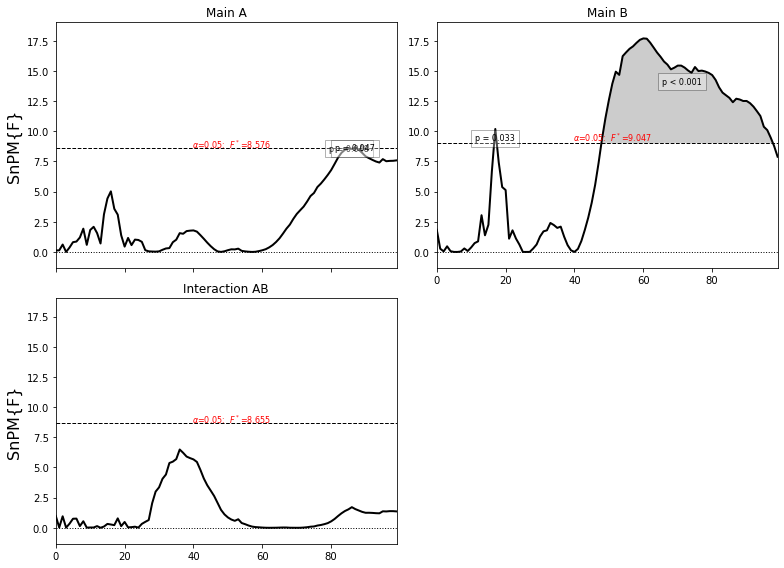

In [44]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [45]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main sex",
        "Main B": "main mass",
        "Interaction AB": "interaction sex-mass",
    },
    mult=1 / y.shape[1],
)
clusters

,effect,p,start,end
0,main sex,0.048,0.847547,0.854567
1,main sex,0.0473333,0.863491,0.874395
2,main mass,0.0326667,0.166757,0.174116
3,main mass,0,0.478377,0.976009


In [46]:
effect = {"main sex": "men", "main mass": "mass", "interaction sex-mass": "men"}
clusters = describe_clusters(
    clusters, box_thorax.rename(columns=dict(box_thorax="value")), effect
)
clusters

,effect,p,start,end,diff desc,mean diff,cohen d,cohen effect
3,main mass,0.0,0.48,0.98,12 - 6,0.03,0.72,medium


In [47]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [48]:
base = alt.Chart(hip_displacement).encode(
    alt.X(
        "index", title="normalized trial", axis=alt.Axis(format="%", labelFlush=False)
    )
)
mu = base.mark_line().encode(
    alt.Y(
        "mean(hip_displacement)",
        axis=alt.Axis(format="%"),
        title="hip vertical displacement (% height)",
    )
)
sigma = base.mark_errorband(extent="ci").encode(alt.Y("hip_displacement", title=None))
men_scale = alt.Scale(scheme="set1")

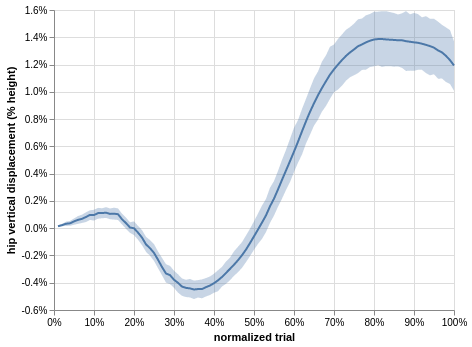

In [49]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

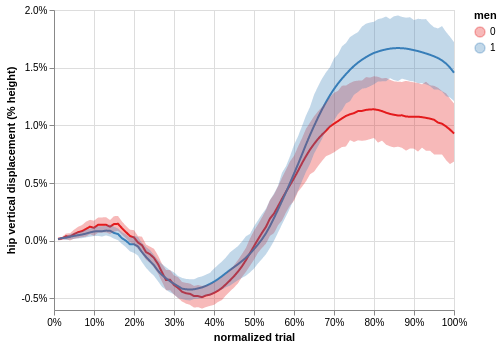

In [50]:
c.transform_filter('datum.effect == "main sex"') + (mu + sigma).encode(
    alt.Color("men:N", scale=men_scale)
)

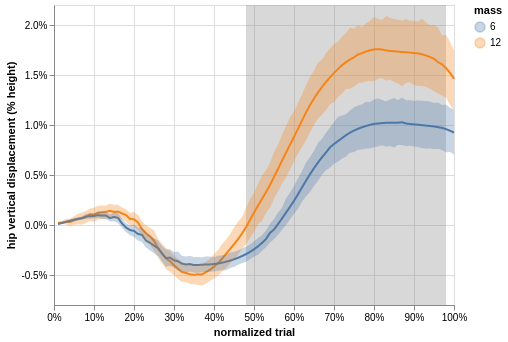

In [51]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

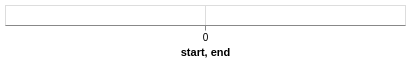

In [52]:
c.transform_filter('datum.effect == "interaction sex-mass"')

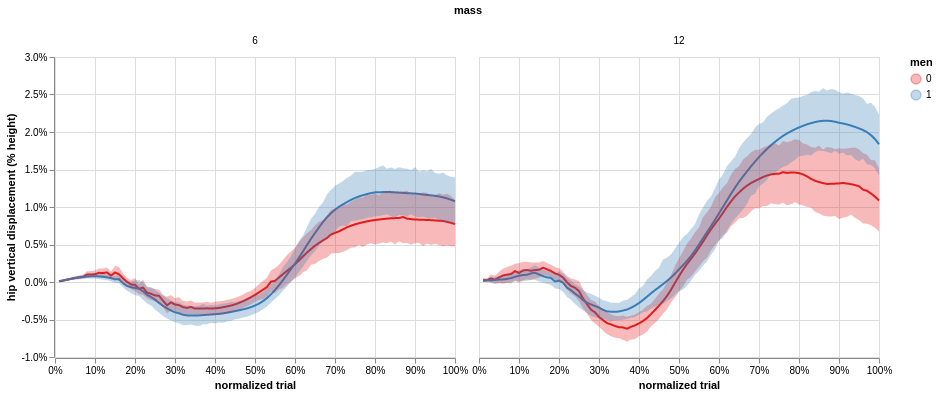

In [53]:
(mu + sigma).encode(alt.Color("men:N", scale=men_scale)).facet(column="mass")

## Box inclination

In [32]:
box_incl = (
    pd.concat(
        [
            Analogs3d.from_mot(ifile)
            .time_normalization()
            .to_dataframe()[["box_rotY"]]
            .assign(filename=ifile.stem)
            for ifile in conf.project_path.glob("*/1_inverse_kinematic/*.mot")
        ]
    )
    .pipe(parse_conditions, suffix="wu_")
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .query("mass != 18 & height == 2")
)

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [46]:
to_bold = lambda x: "\033[1m" + x + "\033[0m"

print(to_bold("Initial"))
condition_counter(box_incl)

Initial
n. participants: 40
----------
men
0    114
1    126
----------
height
2    240
----------
mass
6     120
12    120
----------
men  mass
0    6       57
     12      57
1    6       63
     12      63
----------


In [47]:
balanced_trials = random_balanced_design(
    box_incl, ["men", "mass"], random_state=RANDOM_SEED
)["filename"].tolist()
box_incl = box_incl.query("filename == @balanced_trials")

print(to_bold("Balanced:"))
condition_counter(box_incl)

Balanced:
n. participants: 40
----------
men
0    114
1    114
----------
height
2    228
----------
mass
6     114
12    114
----------
men  mass
0    6       57
     12      57
1    6       57
     12      57
----------


### Stats

In [48]:
id_vars = ["filename", "participant", "men", "height", "mass", "n_trial", "index"]
y = (
    box_incl.assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index(id_vars)
    .unstack()
)
y = y.fillna(y.mean())

y.head()

box_rotY                      \
index                                                0.00      0.01      0.02   
filename    participant men height mass n_trial                                 
VerCF6H2_2  37          0   2      6    2       -0.071158 -0.076242 -0.085452   
VerCF12H2_3 37          0   2      12   3       -0.009264 -0.018573 -0.014573   
VerCF6H2_1  37          0   2      6    1       -0.072524 -0.062117 -0.069048   
VerCF12H2_2 37          0   2      12   2       -0.040455 -0.030781 -0.048211   
VerCF6H2_3  37          0   2      6    3       -0.065679 -0.070749 -0.076233   

                                                                               \
index                                                0.03      0.04      0.05   
filename    participant men height mass n_trial                                 
VerCF6H2_2  37          0   2      6    2       -0.103708 -0.097241 -0.113162   
VerCF12H2_3 37          0   2      12   3       -0.004224 -0.012667 -0.013660   
VerCF6H2_1  37          0   2      6    1       -0.085744 -0.095541 -0.004661   
VerCF12H2_2 37          0   2      12   2       -0.042907 -0.051386 -0.065951   
VerCF6H2_3  37          0   2      6    3       -0.084797 -0.098515 -0.112677   

                                                                               \
index                                                0.06      0.07      0.08   
filename    participant men height mass n_trial                                 
VerCF6H2_2  37          0   2      6    2       -0.133976 -0.146747 -0.227633   
VerCF12H2_3 37          0   2      12   3       -0.026019 -0.063381 -0.136831   
VerCF6H2_1  37          0   2      6    1       -0.024527  0.000715  0.058182   
VerCF12H2_2 37          0   2      12   2       -0.052445 -0.080458 -0.044940   
VerCF6H2_3  37          0   2      6    3       -0.158566 -0.213254 -0.313821   

                                                           ...            \
index                                                0.09  ...      0.91   
filename    participant men height mass n_trial            ...             
VerCF6H2_2  37          0   2      6    2       -0.501209  ...  0.300984   
VerCF12H2_3 37          0   2      12   3       -0.194731  ...  0.278481   
VerCF6H2_1  37          0   2      6    1        0.048257  ...  0.346287   
VerCF12H2_2 37          0   2      12   2        0.014924  ...  0.223002   
VerCF6H2_3  37          0   2      6    3       -0.402635  ...  0.359575   

                                                                               \
index                                                0.92      0.93      0.94   
filename    participant men height mass n_trial                                 
VerCF6H2_2  37          0   2      6    2        0.297583  0.286589  0.105273   
VerCF12H2_3 37          0   2      12   3        0.252241  0.270395  0.266160   
VerCF6H2_1  37          0   2      6    1        0.323573  0.338829  0.324097   
VerCF12H2_2 37          0   2      12   2        0.213945  0.178290  0.187304   
VerCF6H2_3  37          0   2      6    3        0.323452  0.334351  0.294551   

                                                                               \
index                                                0.95      0.96      0.97   
filename    participant men height mass n_trial                                 
VerCF6H2_2  37          0   2      6    2        0.277483  0.282854  0.286339   
VerCF12H2_3 37          0   2      12   3        0.250519  0.250093  0.250847   
VerCF6H2_1  37          0   2      6    1        0.299324  0.312567  0.298606   
VerCF12H2_2 37          0   2      12   2        0.183285  0.195693  0.196291   
VerCF6H2_3  37          0   2      6    3        0.344698  0.309033  0.268882   

                                                                               
index                                                0.98      0.99      1.00  
filename    participant men height 

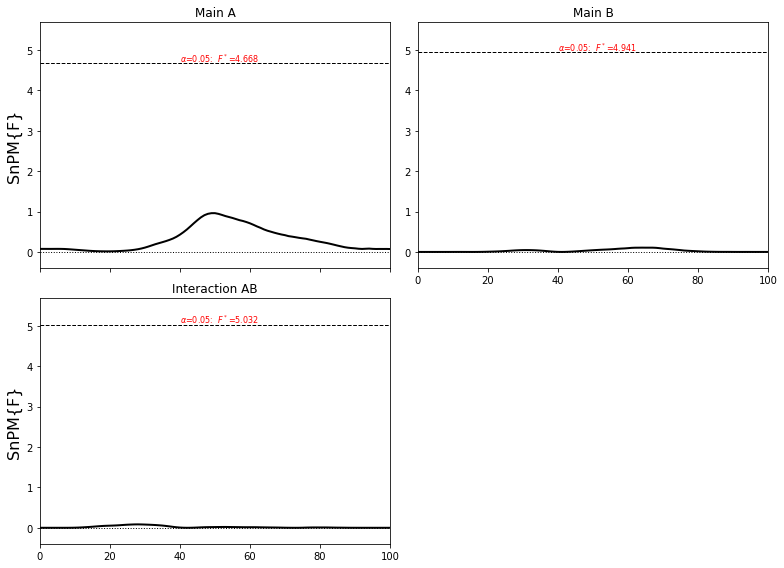

In [49]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(), A=y.index.get_level_values("men"), B=y.index.get_level_values("mass")
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [59]:
base = alt.Chart(box_incl).encode(
    alt.X("index", title="normalized trial", axis=alt.Axis(format="%"))
)
mu = base.mark_line().encode(alt.Y("mean(box_rotY)", title="box inclination (mm)"))
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("box_rotY", title=None))

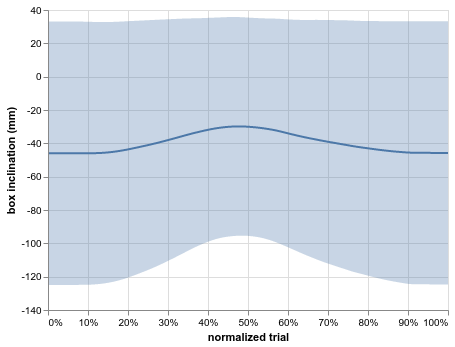

In [60]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

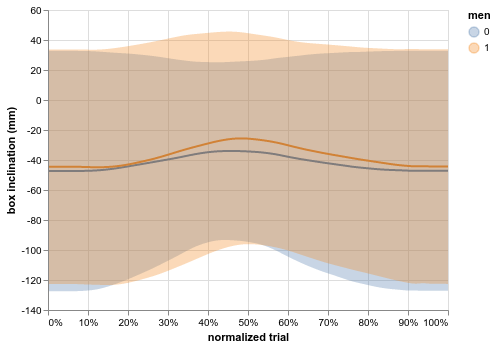

In [61]:
(mu + sigma).encode(alt.Color("men:N"))

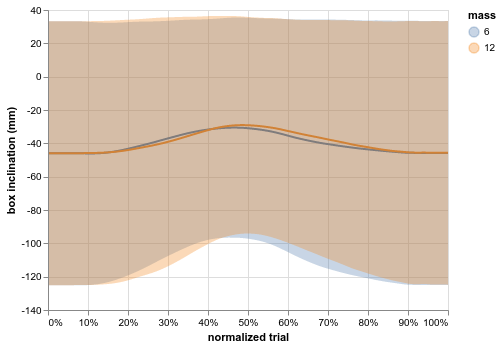

In [62]:
(mu + sigma).encode(alt.Color("mass:N"))

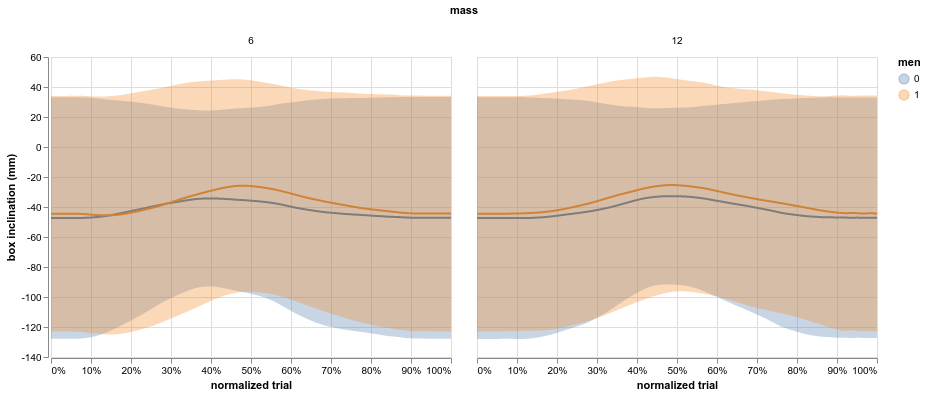

In [63]:
(mu + sigma).encode(alt.Color("men:N")).facet(column="mass")

<!--NAVIGATION-->
< [Joint reactions](02.02-joint-reactions.ipynb) | [Contents](Index.ipynb) | [Analyses](03.00-experts-novices.ipynb) >